# About this notebook

This notebook was written for the [2016 Construction grammar course](http://budling.hu/elmnyelv/index.php/Constructions2016) at the [Department of Theoretical Linguistics](http://www.nytud.hu/tlp/index.html). In this experiment, we try to establish if there are preverbs which correlate with certain argument types to a statistically significant extent. This is also an introductory notebook, which touches on some advanced topics, such as `DataFrame` joining and data plotting. For the first part of the introduction, refer to the [Pandas tutorial](Pandas tutorial.ipynb)

## Initialization

### Basic setup

The first part of the file shows how to download the corpus to your computer and then how to load it into a [Pandas](http://pandas.pydata.org/) *dataframe* (i.e. table).

In [1]:
import pandas as pd
# So that plots work correctly
%matplotlib inline   

import matplotlib
import numpy as np
from IPython.display import display  # For display()

By default, the code in this notebook creates files in the current directory, i.e. the one from which you started the notebook. To use a different directory, just change the value of the `work_directory` variable.

In [2]:
import os

work_directory = os.path.abspath('.')
data_file = 'tade.tsv'

if not os.path.isdir(work_directory):
    os.makedirs(work_directory)
os.chdir(work_directory)

print("The working directory is: " + os.getcwd())

The working directory is: /run/shm/Tade-corpus-tools/notebooks


Finally, we set up plotting. It would work without these commands (since we imported `matplotlib` above), but it looks nicer this way.

In [3]:
matplotlib.style.use('ggplot')
#pd.set_option('display.mpl_style', 'default')
matplotlib.pyplot.rcParams['figure.figsize'] = (15, 3)
matplotlib.pyplot.rcParams['font.family'] = 'sans-serif'

### Getting the data into a table

The first step is to download the Tádé file if it is not downloaded yet. Remember to execute the cell above before this one so that you are in the data directory you specified.

In [4]:
if not os.path.exists(data_file):
    import urllib
    u = urllib.request.URLopener()
    print('Downloading Tádé...')
    u.retrieve('http://people.mokk.bme.hu/~recski/verb_clusters/tade.tsv', 'tade.tsv')
    print('Done.')
else:
    print('Tádé is already downloaded.')

Tádé is already downloaded.


Now that we have the file, we can read it into a `DataFrame` and start working on our experiments... The file is in the Latin-2 (ISO-8859-2) encoding, which is not the default in Python (nor in the modern world) -- that title belongs to utf-8. So in order to be able to properly load the file, we need to specify the encoding as well.

In [5]:
column_names = ['verb', 'frame', 'frame_freq', 'verb_freq', 'freq_ratio']
df = pd.read_table(data_file, encoding='latin2', sep='\t', names=column_names)
df.frame = df.frame.apply(str.upper)
print('Loaded ' + data_file + '; read ' + str(len(df)) + ' lines. The first five lines are:')
df.head()

Loaded tade.tsv; read 1158484 lines. The first five lines are:


,verb,frame,frame_freq,verb_freq,freq_ratio
0,van,@,362298,908829,0.398643
1,van,NP<CAS<INE>>,71800,908829,0.079003
2,van,NP<CAS<DAT>>,56905,908829,0.062614
3,van,NP<CAS<SBL>>,35869,908829,0.039467
4,van,NP<CAS<SUE>>,29836,908829,0.032829


## Significant Arguments

Now we can start with the real experiment. We will use [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher's_exact_test) to evaluate the correlation between preverb and argument. An implementation is available in the [scipy library](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html), which was brought along by Pandas. Basically what we will measure is the odds of a preverb co-occuring with and without an argument (e.g. _rá_ and _CAS&lt;SBL&gt;_, and _rá_ only) vs the same odds for verbs without the preverb (i.e. frames with and without _CAS&lt;SBL&gt;_). This will give us the so called _p-value_, which tells us the probability of the the correlation **NOT** holding.

### Data transformations

Unfortunately, the data, in its current format, is not the best suited for the calculations we need. So a few transformations are in order:

1. The _INF_ frame is not recorded explicitly in the `frame` column; rather, the lemma of infinite verb is appended to the finite one, e.g. `akar_fut`. For such rows, we will delete the part after the underscore and add _INF_ to the frame.
1. The empty frame is marked with an at sign (`@`). Since we don't care about those (but we could!), we shall change these frames to `np.nan`. The _NaN_ (Not a Number) value tells Pandas that the cell is empty, and is valid for all column types (as opposed to e.g. 0, which is only valid for numeric columns). An added bonus is that such cells are not taken into account when grouping by the column, which we will need to do.
1. Actually, we don't really care about the verbs at all, only the preverbs. So we will add a column to the frame that stores only the preverb, i.e. the part before the `+` in verbs such as `meg+próbál`.
1. Finally, if there is a compound argument, such as `NP<CAS<ACC>>_NP<CAS<DAT>>`, we will have to count it both for _ACC_ and _DAT_. It will be much easier if we split such rows into as many rows as there are arguments, and just have a single argument per row. So in this case, we duplicate the row, and keep each cell as-is, with the exception of `frame`, which will be `NP<CAS<ACC>>` in the first row and `NP<CAS<DAT>>` in the second.

The functions below implement these changes.

In [6]:
def split_frames(df):
    """
    Splits the frames into individual arguments and creates as many copies of the row
    as there are arguments in the frame. Makes certain calculations easier.
    """
    s = df.frame.str.split('_').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1)  # Drops the second-level index (0, 1, ...) created by stack()
    s.name = 'frame'                 # Needs a name for join
    return df.drop('frame', axis=1).join(s)[df.columns]  # Keep the original column order

def normalize_frames(df, in_place=True):
    """
    This function does two things: first, it adds INF as a frame if the verb is a modal
    (i.e. the 'verb' column is of the format FiniteVerb_InfiniteVerb). Second, it replaces
    the '@' (empty) frame marker with numpy.nan for better grouping support later on.
    """
    df_ret = df if in_place else df.copy(deep=True)
    df_ret.frame = df_ret.frame.apply(lambda s: 'INF' if s == '@' else s + '_INF').where(
        df_ret.verb.str.contains('_', regex=False), other=df_ret.frame)
    df_ret.loc[df_ret.verb.str.contains('_', regex=False), 'verb'] = df_ret.verb.str.replace('_.*', '')
    #df_ret.loc[df_ret.frame == '@', 'frame'] = np.nan
    return df_ret

def add_preverb_column(df):
    """Adds a preverb column to the data frame."""
    return df.assign(preverb=df.verb.str.replace('[+].+', '').where(df.verb.str.contains('+', regex=False)))

***Note***: `split_frames` will not work on non-server machines, as it requires too much memory. So we are going to use another method; see below.

### Culling the data

Unfortunately, even if the original data fits into the memory of a moderately recent notebook, the frame with the split frames takes up about 3 times as much space, and will find even 8G scarce. So it is best if we remove columns that we do not need, which (after calling `add_preverb_column()`) might include even the `verb` column; however, this one we keep so that we can later validate our results by hand if we so wish.

In [7]:
df.drop(['verb_freq', 'freq_ratio'], axis=1, inplace=True)
display(df.head())
#df = add_preverb_column(normalize_frames(df)).drop('verb', axis=1)
df = add_preverb_column(normalize_frames(df))

,verb,frame,frame_freq
0,van,@,362298
1,van,NP<CAS<INE>>,71800
2,van,NP<CAS<DAT>>,56905
3,van,NP<CAS<SBL>>,35869
4,van,NP<CAS<SUE>>,29836


### Plotting

Running the functions above on our table results in a much easier-to-handle one. One thing that is really a one-liner now is to get the number of times each preverb or argument occurs in the corpus; it is just a matter of grouping the table and aggregating the rows:

1. If we aggregate with `count()` (the column is not important in this case), we will get for each preverb the number of verbs it attaches to.
1. Aggregating the `frame_freq` column by `preverb` with `sum()` tells us the number of times each preverb occurs. These two aggregations should be done **before** splitting the frames, otherwise the duplicated frequencies that help us in the second case mess up things.
1. After splitting the frames, aggregating the `frame_freq` column by `frame` with `sum()` gives us the raw number of times an argument occurs in the corpus.
1. Finally, grouping by both preverb and argument gives us the co-occurrance table.

In [8]:
print("df_with_preverbs.info:\n{}\n".format(df.info()))
def real_frame_size(df):
    import sys
    return sum(sum(df[c].apply(sys.getsizeof)) for c in df.columns)
print(real_frame_size(df))

preverb_counts = df[['preverb', 'frame_freq']].rename(columns={'frame_freq': 'count'}).groupby('preverb').count()
preverb_sums = df[['preverb', 'frame_freq']].rename(columns={'frame_freq': 'B'}).groupby('preverb').sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158484 entries, 0 to 1158483
Data columns (total 4 columns):
verb          1158484 non-null object
frame         1158484 non-null object
frame_freq    1158484 non-null int64
preverb       340906 non-null object
dtypes: int64(1), object(3)
memory usage: 35.4+ MB
df_with_preverbs.info:
None

262648177


In [9]:
#s = df.frame.str.split('_').apply(pd.Series, 1)
from functools import reduce
frames = reduce(lambda acc, e: acc | set(e.split('_')) if type(e) == str else acc, df.frame, set())
len(frames)

416

In [10]:
## Too damn bloody slow
#for frame in frames:
#    df[frame] = df.apply(lambda row: frame in row['frame'] if type(row['frame']) == str else False, axis=1)

from collections import Counter

def count_stuff(df):
    # This is a f*cking shame
    frame_counter = Counter()
    cell_counter = Counter()
    for t in df.itertuples():
        for frame in set(t.frame.split('_')):
            frame_counter[frame] += t.frame_freq
            # Skip NaN "preverbs" -- again, why doesn't NaN evaluate to False?!
            if type(t.preverb) == str:
                cell_counter[(t.preverb, frame)] += t.frame_freq
    return frame_counter, cell_counter

frame_counter, cell_counter = count_stuff(df)

In [11]:
frame_sums = pd.DataFrame(list(frame_counter.items()), columns=['frame', 'C']).set_index('frame')
cells = pd.DataFrame(list((pf[0], pf[1], a) for pf, a in cell_counter.items()), columns=['preverb', 'frame', 'A']).set_index(['preverb', 'frame'])

***Note***: The names (_A_, _B_, _C_, _D_ are the same as on the [Wikipedia page](https://en.wikipedia.org/wiki/Fisher's_exact_test).)

We could print the content of these tables to see e.g. the number of different verbs for each preverb, but for the more visual types out there, there is another option: plotting. The histogram below shows just this (note the sorting, and also how we aggregate the rest of the preverbs):

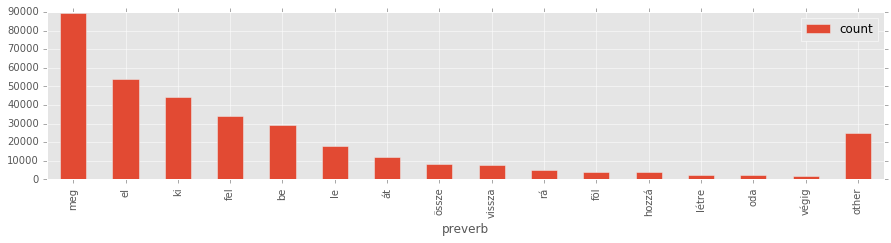

In [12]:
def capped_sorted_list(lst, by, cutoff=0, other='other'):
    """
    Sorts a data frame by the specified column decreasingly. It allows the user to
    specify a cutoff; all items with indices above this cutoff are aggregated under
    (with sum) under an "other" item.
    """
    slst = lst.sort_values(by=by, ascending=False)
    if cutoff > 0:
        slst = slst[:cutoff].append(
            pd.DataFrame([[other, slst[cutoff:].sum()[0]]],
                         columns=lst.index.names + list(lst.columns.values)).set_index(lst.index.names)
        )
    return slst

capped_sorted_list(preverb_counts, by='count', cutoff=15).plot(y='count', kind='bar')


We can also display the number of frames for the top arguments and preverbs. Let's do it in two pie charts!

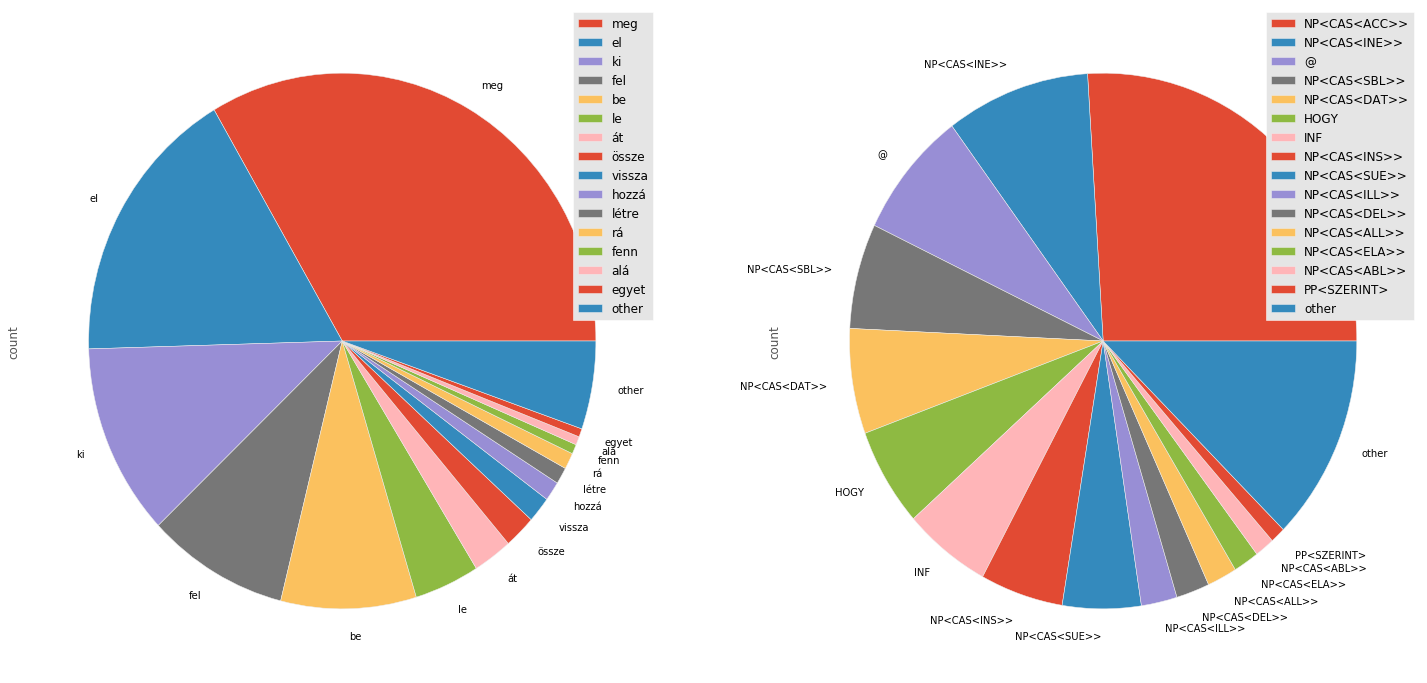

In [13]:
capped_sorted_list(preverb_sums, by='B', cutoff=15).rename(columns={'B': 'count'})
capped_sorted_list(frame_sums, by='C', cutoff=15).rename(columns={'C': 'count'})

matplotlib.pyplot.rcParams['figure.figsize'] = (25, 12)
fig, axs = matplotlib.pylab.subplots(1,2)
capped_sorted_list(preverb_sums, by='B', cutoff=15).rename(columns={'B': 'count'}).plot(y='count', kind='pie', ax=axs[0])
capped_sorted_list(frame_sums, by='C', cutoff=15).rename(columns={'C': 'count'}).plot(y='count', kind='pie', ax=axs[1])

# If you wanted just one pie chart, all this figure/axis stuff is superfluous, and you could just:
#
# matplotlib.pyplot.rcParams['figure.figsize'] = (10, 10)
# capped_sorted_list(preverb_counts, by='count', cutoff=15).plot(y='count', kind='pie')

### Results

Now we are ready to move in for the kill. All we need to do is
1. join our `A`, `B`, `C` tables, add a `D` column, so that we have everything in one place
1. compute the p-value with Fisher's exact test.

In [14]:
def display_all(df):
    with pd.option_context("display.max_rows", len(df)):
        display(df)

full = cells.join(preverb_sums).join(frame_sums)
full['D'] = df.frame_freq.sum()
full['B'] -= full['A']
full['C'] -= full['A']
full['D'] -= (full['A'] + full['B'] + full['C'])

from scipy.stats import fisher_exact

full['Fisher'] = full.apply(lambda row: fisher_exact([[row.A, row.B], [row.C, row.D]])[1], axis=1)

Geez, did that take a long time... however, the good news is that we are done. Of course, we don't care about all the numbers, so let's set up thresholds:
- `A / B` (ratio of the frame amongst all verbs with the preverb) should be greater than `0.2`;
- the _p-value_ should be less than 1e-30.

Also, before displaying the results, let's add the number of verbs with the preverb to the table so that we have an idea how much of the correlation comes from the preverb and how much from the verb.

In [15]:
full = full.join(preverb_counts)

In [16]:
significant_correlations = full[(full.A / full.B >= 0.2) & (full.Fisher <= 1e-30)].sort_index()
display_all(significant_correlations)
#display(only.loc[only.index.levels[0] == 'rá'])

A       B        C        D         Fisher  count
preverb   frame                                                               
agyon     NP<CAS<ACC>>     487     215  4743118  5222333   2.634119e-31    165
alá       NP<CAS<ACC>>   10299    2079  4733306  5220469   0.000000e+00   1637
be        NP<CAS<ACC>>  106794  103929  4636811  5118619  3.842626e-180  28994
          NP<CAS<ILL>>   38796  171927   378928  9376502   0.000000e+00  28994
bele      NP<CAS<ACC>>    1048    1991  4742557  5220557   2.225248e-48    975
          NP<CAS<ILL>>    1835    1204   415889  9547225   0.000000e+00    975
békén     @                154     148  1411014  8554837   1.167121e-51     21
egybe     NP<CAS<ACC>>     545    1866  4743060  5220682  7.622484e-142    525
          NP<CAS<INS>>    1370    1041   964784  8998958   0.000000e+00    525
egyet     @               2818    9433  1408350  8545552  5.973280e-151   1094
          HOGY            3679    8572  1082939  8870963   0.000000e+00   1094
          NP<CAS<INE>>    3220    9031  1674510  8279392  1.983598e-152   1094
          NP<CAS<INS>>    7133    5118   959021  8994881   0.000000e+00   1094
együtt    NP<CAS<INE>>     672    1718  1677058  8286705   6.793820e-43    361
          NP<CAS<INS>>    1739     651   964415  8999348   0.000000e+00    361
el        @              69486  347071  1341682  8207914   0.000000e+00  53950
          NP<CAS<ACC>>  221136  195421  4522469  5027127   0.000000e+00  53950
elő       @               1180    3554  1409988  8551431   3.441126e-85    763
          NP<CAS<ACC>>    1237    3497  4742368  5219051  1.479017e-201    763
          NP<CAS<ELA>>     972    3762   297913  9663506   0.000000e+00    763
fel       NP<CAS<ACC>>  139402   80800  4604203  5141748   0.000000e+00  34065
          NP<CAS<SBL>>   41153  179049  1118891  8627060   0.000000e+00  34065
fenn      NP<CAS<ACC>>    9954    4297  4733651  5218251   0.000000e+00   1432
félre     @                662    1315  1410506  8553670  4.924052e-104    440
föl       @               2329    9777  1408839  8545208   4.006324e-53   4054
fölül     PP<ALAPJÁN>       31      15    85806  9880301   4.382404e-53     11
          PP<SORÁN>         31      15    62175  9903932   2.093048e-57     11
haza      @               2856    4816  1408312  8550169   0.000000e+00   1388
          NP<CAS<ACC>>    1500    6172  4742105  5216376   0.000000e+00   1388
hozzá     HOGY            6038   22557  1080580  8856978   0.000000e+00   3794
          NP<CAS<ACC>>    7130   21465  4736475  5201083   0.000000e+00   3794
          NP<CAS<ALL>>   18836    9759   328315  9609243   0.000000e+00   3794
hátra     @               2225     969  1408943  8554016   0.000000e+00    407
ide       @                856    1451  1410312  8553534  1.540034e-164    616
jól       @                292     535  1410876  8554450   3.085542e-52    177
jóvá      NP<CAS<ACC>>    4527     678  4739078  5221870   0.000000e+00    558
keresztül NP<CAS<SUE>>     771     164   911898  9053320   0.000000e+00    272
ki        NP<CAS<ACC>>  153227  130766  4590378  5091782   0.000000e+00  44410
körbe     @                417    1239  1410751  8553746   3.232391e-32    534
körül     @               1181    2957  1409987  8552028  3.161129e-126    641
közbe     @                607     180  1410561  8554805   0.000000e+00    106
közzé     NP<CAS<ACC>>    7045     413  4736560  5222135   0.000000e+00    653
          NP<CAS<INE>>    4027    3431  1673703  8284992   0.000000e+00    653
külön     NP<CAS<SBL>>     194     498  1159850  8805611   1.159930e-31    237
le        @              18886   82482  1392282  8472503   0.000000e+00  17711
          NP<CAS<INE>>   18837   82531  1658893  8205892   2.625341e-49  17711
létre     NP<CAS<INE>>    5650   18972  1672080  8269451  1.259575e-133   2561
          NP<CAS<INS>>    5179   19443   960975  8980556   0.000000e+00   2561
meg       NP<CAS<ACC>>  472220  344997  4271385  4877551   0.000000e+00  89657


In [21]:
len(df[df.preverb == 'be'].groupby('verb'))

1105

In [69]:
s = df.groupby(['preverb', 'verb']).first().reset_index(level='verb').index.value_counts()
s.index.name = 'preverb'
s.name = 'ehe'
#aha = df[['preverb', 'verb', 'frame']].groupby(['preverb', 'verb']).first().reset_index().drop('frame', axis=1).groupby('preverb').count().rename(columns={'verb': 'aha'})
#oho = df[['preverb', 'verb', 'frame']].groupby(['preverb', 'verb']).first().groupby(level='preverb').count().rename(columns={'frame': 'oho'})
significant_correlations.join(s)

A       B        C        D         Fisher  \
preverb   frame                                                           
agyon     NP<CAS<ACC>>     487     215  4743118  5222333   2.634119e-31   
alá       NP<CAS<ACC>>   10299    2079  4733306  5220469   0.000000e+00   
be        NP<CAS<ACC>>  106794  103929  4636811  5118619  3.842626e-180   
          NP<CAS<ILL>>   38796  171927   378928  9376502   0.000000e+00   
bele      NP<CAS<ACC>>    1048    1991  4742557  5220557   2.225248e-48   
          NP<CAS<ILL>>    1835    1204   415889  9547225   0.000000e+00   
békén     @                154     148  1411014  8554837   1.167121e-51   
egybe     NP<CAS<ACC>>     545    1866  4743060  5220682  7.622484e-142   
          NP<CAS<INS>>    1370    1041   964784  8998958   0.000000e+00   
egyet     @               2818    9433  1408350  8545552  5.973280e-151   
          HOGY            3679    8572  1082939  8870963   0.000000e+00   
          NP<CAS<INE>>    3220    9031  1674510  8279392  1.983598e-152   
          NP<CAS<INS>>    7133    5118   959021  8994881   0.000000e+00   
együtt    NP<CAS<INE>>     672    1718  1677058  8286705   6.793820e-43   
          NP<CAS<INS>>    1739     651   964415  8999348   0.000000e+00   
el        @              69486  347071  1341682  8207914   0.000000e+00   
          NP<CAS<ACC>>  221136  195421  4522469  5027127   0.000000e+00   
elő       @               1180    3554  1409988  8551431   3.441126e-85   
          NP<CAS<ACC>>    1237    3497  4742368  5219051  1.479017e-201   
          NP<CAS<ELA>>     972    3762   297913  9663506   0.000000e+00   
fel       NP<CAS<ACC>>  139402   80800  4604203  5141748   0.000000e+00   
          NP<CAS<SBL>>   41153  179049  1118891  8627060   0.000000e+00   
fenn      NP<CAS<ACC>>    9954    4297  4733651  5218251   0.000000e+00   
félre     @                662    1315  1410506  8553670  4.924052e-104   
föl       @               2329    9777  1408839  8545208   4.006324e-53   
fölül     PP<ALAPJÁN>       31      15    85806  9880301   4.382404e-53   
          PP<SORÁN>         31      15    62175  9903932   2.093048e-57   
haza      @               2856    4816  1408312  8550169   0.000000e+00   
          NP<CAS<ACC>>    1500    6172  4742105  5216376   0.000000e+00   
hozzá     HOGY            6038   22557  1080580  8856978   0.000000e+00   
...                        ...     ...      ...      ...            ...   
rá        NP<CAS<SBL>>   13331   10587  1146713  8795522   0.000000e+00   
szembe    NP<CAS<ACC>>     702    2414  4742903  5220134  4.508487e-184   
          NP<CAS<INS>>    2487     629   963667  8999370   0.000000e+00   
számba    NP<CAS<ACC>>     483      59  4743122  5222489   4.322415e-93   
szét      @               1171    4756  1409997  8550229   4.967308e-32   
tele      NP<CAS<INS>>     306     298   965848  8999701  1.048927e-143   
teli      @                999    1754  1410169  8553231  1.171467e-183   
          NP<CAS<INS>>     563    2190   965591  8997809   5.635040e-64   
tova      @                 89      61  1411079  8554924   1.918376e-37   
tovább    @                971    2949  1410197  8552036   6.111676e-69   
tudomásul HOGY            1506    1297  1085112  8878238   0.000000e+00   
          NP<CAS<ACC>>    2041     762  4741564  5221786  8.344749e-162   
          NP<CAS<INS>>     471    2332   965683  8997667   1.920818e-31   
tönkre    NP<CAS<ACC>>     831     412  4742774  5222136   1.710385e-42   
túl       NP<CAS<SUE>>    1371    2599   911298  9050885   0.000000e+00   
utána     @                350     423  1410818  8554562   3.646517e-96   
utánaoda  NP<CAS<ALL>>      27       2   347124  9619000   1.629981e-37   
vissza    NP<CAS<ACC>>   13040   25042  4730565  5197506   0.000000e+00   
          NP<CAS<SBL>>    8630   29452  1151414  8776657   0.000000e+00   
végbe     NP<CAS<INE>>     726     865  1677004  8287558  4.539880e-157   
végig     NP<CAS<ACC>>    3987    3033  4739618  52195